In [1]:
import sys
sys.path.append('../')
import utils_auto 

# Configuration

In [2]:
trial_idx=1
paper='1106.6060'

# Code-generation prompts

In [24]:
prompt=(utils_auto.generate_prompt(template='prompt.md',docstring='docstring.md',paper=paper,save=True,trial_idx=trial_idx))

In [25]:
print(prompt)

You are a condensed matter physicist working on the numerical calculation for the Hamiltonian of a system using the Hartree Fock method. I will provide you with the physical Hamiltonian written in second quantized form as an equation in LaTeX. You should convert it into a class for the HartreeFockHamiltonian using Python and necessary packages, such as numpy and scipy.
This is a multiple-step problem, and you will execute this process by analyzing the equation and answering smaller questions sequentially in order to finally generate the class. The class has the following structure:

CLASS DOCSTRING: 
```
class HartreeFockHamiltonian:
  def __init__(self, N_shell, parameters:dict[str, Any], filling_factor: float=0.5):
    self.lattice = 'square' | 'triangular'
    self.D = # LLM Task: has to define this tuple.
    self.basis_order = {'0': 'flavor_type_0', '1': 'flavor_type_1', ... 'D-1': 'flavor_type_D-1'}
    # this is the basis order that the Hamiltonian will follow

    # Occupancy r

# LLM-Generated code

In [26]:
generated_code = utils_auto.code_generate(prompt,max_tokens=25600,budget_tokens=12800,)


#################### THINKING ####################

Let's break down
Let's break down the Hamiltonian equation step by step to understand the system we're dealing with and how to implement it.

#### UNDERSTANDING THE HAMILTONIAN

The Hamiltonian is in the form:
$$\HH_{\rm MF} = \sum_{\kk, s} \hat{C}^{\dag}_{\kk s}\HH_{\kk s}\hat{C}^{\phantom{\dag}}_{\kk s} + f(n^{p}, \eta)$$

Where $\hat{C}^{\dag}_{\kk s} = (\hat{p}^{\dag}_{x\kk s}, \hat{p}^{\dag}_{y\kk s}, \hat{d}^{\dag}_{\kk s})$, which tells us that we have a 3-component spinor, consisting of:
- $\hat{p}^{\dag}_{x\kk s}$: creation operator for a hole with spin s on the oxygen px orbital
- $\hat{p}^{\dag}_{y\kk s}$: creation operator for a hole with spin s on the oxygen py orbital
- $\hat{d}^{\dag}_{\kk s}$: creation operator for a hole with spin s on the copper d orbital

And $\HH_{\kk s}$ is a 3x3 matrix with elements dependent on k.

The term $f(n^{p}, \eta)$ is a function of the total hole density on oxygen sites $n^p$ and a nem

In [27]:
code = utils_auto.extract_code(generated_code['text'])

In [28]:
print(code)

import numpy as np
from typing import Any
from HF import *

class HartreeFockHamiltonian:
    """
    Implementation of the Hartree-Fock Hamiltonian for a three-orbital model (px, py, d)
    with spin degrees of freedom on a square lattice.
    
    Args:
        N_shell (int): Number of shells in the first Brillouin zone.
        parameters (dict): Dictionary containing model parameters.
        filling_factor (float): Filling factor, default is 0.5.
    """
    def __init__(self, N_shell: int, parameters: dict[str, Any]={}, filling_factor: float=0.5):
        self.lattice = 'square'  # Lattice type
        self.D = (2, 3)  # (spin, orbital)
        self.basis_order = {'0': 'spin', '1': 'orbital'}
        # Order for each flavor:
        # 0: spin up, spin down
        # 1: px, py, d

        # Occupancy relevant parameters
        self.nu = filling_factor
        self.T = parameters.get('T', 0)  # Temperature, default to 0
        self.a = parameters.get('a', 1.0)  # Lattice constant

In [29]:
utils_auto.save_code(code,paper,trial_idx)

Code saved to code_1106_6060_11.py


# Code execution

In [ ]:
code_path = 'code_{int}_{decimal}_{trial_idx}'.format(int=paper.split('.')[0],decimal=paper.split('.')[1],trial_idx=trial_idx) 

In [4]:
import importlib

In [5]:
module = importlib.import_module(code_path)

In [6]:
import HF

## Task 1: Brillouin Zone k-mesh check

In [7]:
ham = module.HartreeFockHamiltonian(N_shell=10,)

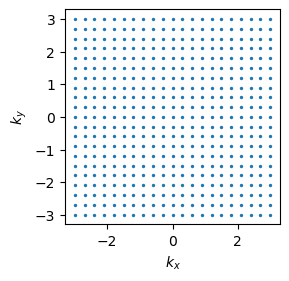

In [8]:
fig1=utils_auto.plot_kspace(kspace=ham.k_space)

## Task 2: Noninteracting energy dispersion:

In [9]:
ham = module.HartreeFockHamiltonian(N_shell=10,parameters={'Delta':0,'U_p':0,'U_d':0,'V_pp':0,'V_pd':1e-5,'t_pd':1,'t_pp':1},filling_factor=1/3)


In [10]:
h_nonint = ham.generate_non_interacting()

In [11]:
wf,en= HF.diagonalize(h_nonint) # or HF.diagonalize

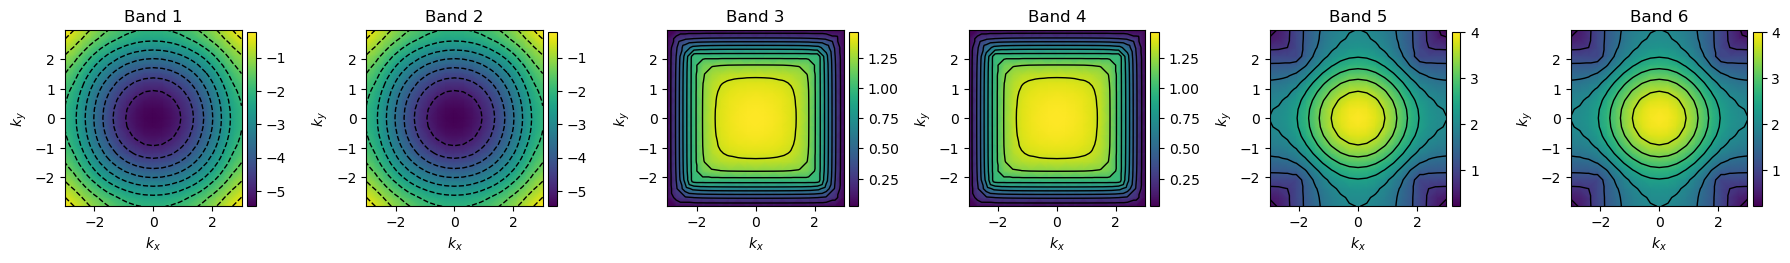

In [12]:
fig2=utils_auto.plot_2d_false_color_map(ham,en)

## Task 3: Weak-coupling limit

In [13]:
ham_int= module.HartreeFockHamiltonian(N_shell=10,  
parameters={'Delta':0,'U_p':0,'U_d':0,'V_pp':0,'V_pd':1e-5,'t_pd':1,'t_pp':1},filling_factor=1/3)

In [14]:
wf,en= HF.diagonalize(ham_int.generate_non_interacting())
exp_val= HF.get_exp_val(wf,en,1/3,0)
exp_val=HF.unflatten(exp_val,ham_int.D,ham.N_k)

In [15]:
wf_int, en_int, exp_val_int= HF.solve(ham_int,exp_val,100)

Convergence reached at iteration 4


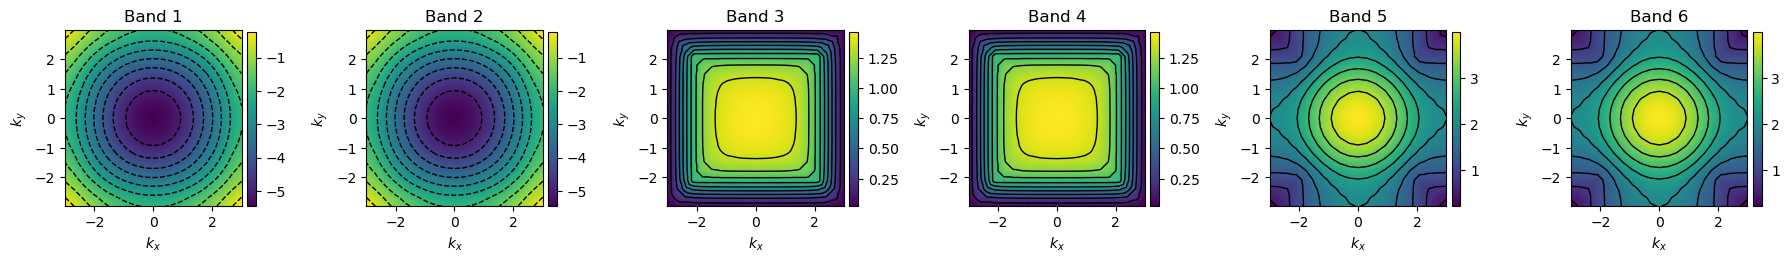

In [16]:
fig3=utils_auto.plot_2d_false_color_map(ham_int,en_int)

## Task 4: Strong-coupling limit

In [17]:
ham_int= module.HartreeFockHamiltonian(N_shell=10,  parameters={'Delta':5,'U_p':0,'U_d':0,'V_pp':0,'V_pd':1e5,'t_pd':1,'t_pp':1},filling_factor=1/3)


In [18]:
h_nonint=ham_int.generate_non_interacting()
h_nonint[:,2,:,2,:]-=100
wf,en=HF.diagonalize(h_nonint)
exp_val=HF.get_exp_val(wf,en,1/3,0)
exp_val=HF.unflatten(exp_val,ham_int.D,ham.N_k)

In [19]:
wf_int, en_int, exp_val_int=HF.solve(ham_int,exp_val,99)

Convergence reached at iteration 2


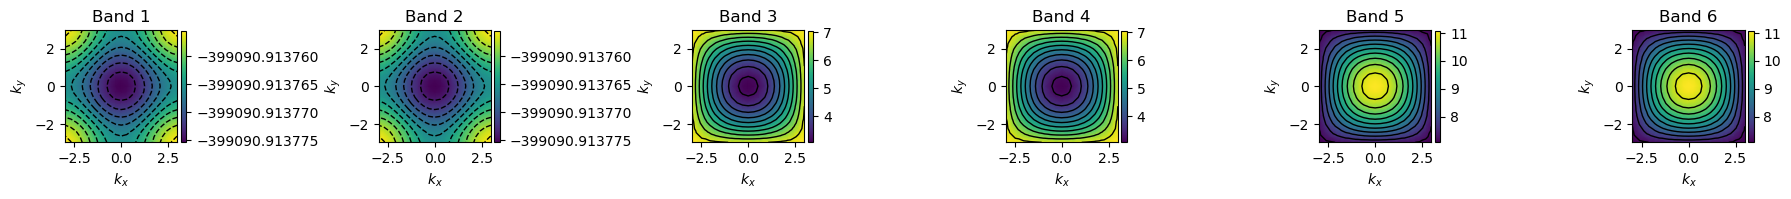

In [20]:
fig4=utils_auto.plot_2d_false_color_map(ham_int,en_int)

In [21]:
utils_auto.print_gap(ham_int,exp_val,en_int,2)

Gap is 399093.97
U/T is 67288.15
mean_U is 31199.43


# Vision Evaluation

## Task 1: Brillouin Zone k-mesh check

In [23]:
result1 = utils_auto.vision_eval(
    fig=fig1, 
    prompt_text=utils_auto.generate_evalution_prompt(rubric='rubrics1.md', image='image1.md', paper=paper),
    max_tokens=6400, budget_tokens=3200,
    )


#################### THINKING ####################

I
I need to analyze the image based on the provided rubric to determine if it correctly represents the momentum space mesh in the first Brillouin zone of the described problem, focusing particularly on the point group symmetry.

Let's break down what I'm seeing in the image and what I need to check:

1. The image shows a grid of blue dots in a square region
2. The x-axis is labeled as k_x and ranges from approximately -3 to 3
3. The y-axis is labeled as k_y and ranges from approximately -3 to 3
4. The dots appear to be arranged in a regular grid pattern

Now let's analyze this against what we know about the problem:

From the Hamiltonian, we can see this is a three-band model (two oxygen p-orbitals and one copper d-orbital) on a square lattice, which is explicitly stated at the end of the problem.

For a square lattice, the first Brillouin zone is a square in k-space, centered at the origin, with boundaries at k_x, k_y = ±π (in units

In [24]:
answer1=utils_auto.extract_result_content(result1['text'])
print(answer1)

correct


## Task 2: Noninteracting energy dispersion

In [25]:
result2 = utils_auto.vision_eval(
    fig=fig2, 
    prompt_text=utils_auto.generate_evalution_prompt(rubric='rubrics2.md', image='image2.md', paper=paper),
    max_tokens=6400, budget_tokens=3200,
    )


#################### THINKING ####################

I
I need to analyze the band structure plots shown in the image and evaluate whether they correctly represent the expected band structure for the Hamiltonian given in the problem.

Let's break this down according to the rubric:

### 1. Identify the shape of the Brillouin zone boundary and confirm it matches what's expected for a square lattice.

Looking at the plots, I can see that each band is plotted within a square boundary in k-space, with k_x and k_y ranging approximately from -3 to 3. The Brillouin zone for a square lattice should be square in k-space, which matches what we see in these plots. So this aspect looks correct.

### 2. Examine the symmetry of the energy distribution shown by the false color plot:

#### 2.1 Identify the highest energy regions (yellow)
- In Bands 1 and 2: The highest energy regions (yellow) are at the edges of the Brillouin zone.
- In Bands 3 and 4: The highest energy regions (yellow) are in the cente

In [26]:
answer2=utils_auto.extract_result_content(result2['text'])
print(answer2)

correct


## Task 3: Weak-coupling limit

In [27]:
result3 = utils_auto.vision_eval(
    fig=fig3, 
    prompt_text=utils_auto.generate_evalution_prompt(rubric='rubrics3.md', image='image3.md', paper=paper, Gap=0, nu='1/3'),
    max_tokens=6400, budget_tokens=3200,
    )


#################### THINKING ####################

Let me
Let me analyze the image systematically according to the rubric requirements.

The image shows a set of 6 false color plots displaying different energy bands in the first Brillouin zone. Each plot shows the energy distribution in momentum space (k-space) with kx and ky axes both ranging from approximately -3 to 3.

Let's go through the rubric criteria:

1. First, identify the shape of the Brillouin zone boundary and confirm it matches what's expected for a square lattice.

Looking at the plots, I can see that the Brillouin zone appears to be square-shaped, with boundaries forming a square in the kx-ky plane. This is consistent with a square lattice in real space, which leads to a square-shaped first Brillouin zone in reciprocal space. So this criterion is met.

2. Examining the symmetry of the energy distribution shown by the false color plot:

2.1 Identify the highest energy regions (yellow):
- In Bands 1 and 2: The highest e

In [28]:
answer3=utils_auto.extract_result_content(result3['text'])
print(answer3)

incorrect


## Task 4: Strong-coupling limit

In [29]:
result4 = utils_auto.vision_eval(
    fig=fig4, 
    prompt_text=utils_auto.generate_evalution_prompt(rubric='rubrics4.md', image='image4.md', paper=paper, nu='1/3',U_int='4*V_pd = 4e5'),
    max_tokens=6400, budget_tokens=3200,
    )


#################### THINKING ####################

I need to analyze
I need to analyze the provided image which shows band structure plots for a square lattice system calculated using the Hartree-Fock method. Let me go through the rubric step by step.

1. Identify the shape of the Brillouin zone boundary:
Looking at the plots, I can see that the Brillouin zone is shown as a square with boundaries at approximately k_x = ±2.5 and k_y = ±2.5. This is consistent with what we would expect for a square lattice, which should have a square first Brillouin zone.

2. Examine the symmetry of the energy distribution:

2.1 Identify the highest energy regions (yellow):
- In Bands 1-4: The highest energy regions appear to be at the edges/corners of the zone
- In Bands 5-6: The highest energy regions (yellow) are at the center of the Brillouin zone

2.2 Trace the pattern of energy variation across the zone:
- Bands 1-2: Show concentric patterns centered at the origin, with energy decreasing from cen

In [30]:
answer4=utils_auto.extract_result_content(result4['text'])
print(answer4)

correct


In [31]:
utils_auto.save_final_answer(paper,trial_idx,answer1,answer2,answer3,answer4)

Final answer record for '1' saved to final_answer.yaml
